# Análisis de acciones de empresas ecuatorianas 
### Junio/2018 - Junio/2021

**Autor:   Juan José Triviño Zambrano**  
**Fecha:   Junio 30, 2021**

Hace exactamente un año ya, de la publicación de mi estudio [Valoración de títulos de renta fija](https://nbviewer.jupyter.org/github/juanjosetz/financial/blob/master/valoracion_titulos.ipynb). Para esta ocasión he creido conveniente hacer en cambio un estudio de renta variable, más especificamente de acciones. Esta vez, no desde la perspectiva de valoración de títulos como se lo hizo en el estudio antes mencionado, sino desde la perspectiva del análisis de los rendimientos históricos que arrojaron las acciones más populares de la década pasada. Para esto haremos uso de ciertos conceptos estadísticos, financieros y bursátiles; todo esto apoyado nuevamente, como no, de nuestra querida "navaja suiza" **Python** con sus estupendas librerías para el manejo, análisis y visualización de datos.

## Fuente de la información
### Bolsa de Valores de Guayaquil

La Bolsa de Valores de Guayaquil a través de su [sitio web](https://www.bolsadevaloresguayaquil.com/valoracion/index.asp), en el apartado de valoración, publica información referente a títulos de renta fija y renta variable. No es la mejor forma de presentar la información (a través de hojas de cálculo), algo que denota la falta de técnica en la publicación de la información. Hay que decir que esto lo viene realizando desde el año 2007 sin que en todos estos años, hayan innovado o mejorado la forma de proporcionar la información a sus usuarios/clientes, cuando hoy en día existen fabulosas herramientas basadas en web, para trabajar con tablas de datos e inclusive bases de datos relacionales. Aún así, "es lo que hay" y se le puede sacar provecho de alguna manera.

La información viene presentada en dos vertientes:
1. **Diaria:** Que regoge la información a diario, la cual solo está disponible en su último día, pues se actualiza cada día laborable.
2. **Histórica:** Que recoge la información mensualmente, para lo cual existe un directorio para todo su historial desde el año 2007.

## Metodología del análisis

El rendimiento de una acción es determinado por dos factores:

1. Revalorización del precio de la acción
2. Dividendos recibidos

En este sentido, seleccionaremos las 10 compañias más representativas en bolsa de los últimos tres años y evaluaremos todas las ganancias de capital y dividendos recibidos a través del período de análisis. Esto no supone mayor difcultad, lo retador es, estructurar todos los datos desde la fuente, dada la rusticidad y desorganización de la información que se presenta.

## Obtención y preparación de datos

### Descarga de los archivos desde el directorio web
Lo que necesitamos ahora es toda la data histórica para después agrupar y consolidar la información a través del tiempo y poder construir una suerte de datos de panel. Para esto tenemos que descargar todos estos reportes mensuales contenidos en los archivos *xls*. Aparentemente estos ficheros solo están disponibles para el año actual y el anterior, pues así se muestra en su pestaña `Histórico`. Los demás ficheros de años anteriores si se encuentran disponibles pero permanecen ocultos de la interfaz web. Para tener acceso a ellos debemos primero ingresar al [directorio](https://www.bolsadevaloresguayaquil.com/valoracion/Historico/) donde están alojados todos estos ficheros. Una vez dentro, ya podemos descargar todos los ficheros y así lo haremos, pero no de la forma ortodoxa de ir descargando uno por uno los archivos, sino que diseñaremos una función para que haga el trabajo por nosotros.
Además de descargarlos, la diseñaremos para que le dé un nombre más adecuado a los archivos `(aa-mm-dd)`, esto para que estén mejor ordenados con un formato estándar de patrón de fecha, algo que nos servirá para asociar cada reporte de precios a una fecha en concreto.

In [1]:
from bs4 import BeautifulSoup
import requests
import re

In [2]:
def descargar_archivos():
    url = "https://www.bolsadevaloresguayaquil.com/valoracion/Historico/"
    codigo_html = requests.get(url).text
    web = BeautifulSoup(codigo_html, "lxml")
    links = web.find_all('a')
    url_links = [url[:39] + links[href].get('href') for href in range(1,len(links))]
    meses = {'Enero':'01', 'Febrero':'02', 'Marzo':'03', 'Abril':'04', 'Mayo':'05', 'Junio':'06',
             'Julio':'07', 'Agosto':'08', 'Septiembre':'09', 'Octubre':'10', 'Noviembre':'11', 'Diciembre':'12'}
    
    for url in url_links:
        idx = url.rfind('/')
        nombre_ini = url[idx+1:]
        lista = re.findall('\d+|\D+', nombre_ini)
        
        if len(lista) == 4:
            nombre_fin = f'{lista[2]}-{meses[lista[1]]}-{lista[0]}{lista[3]}'
            resp = requests.get(url)
            
            with open(nombre_fin, 'wb') as output:
                output.write(resp.content)

## Operaciones con los ficheros descargados

### Extrayendo la data de los archivos

>Uno de los problemas (de los tantos) de las hojas de cálculo, es que la información suele venir 'desorganizada y sucia'. No hay problema, diseñaremos un programa que nos permita extraer la data relevante para nuestro análisis, descartando la información que no vayamos a utilizar.

El algoritmo siguiente extrae los datos relevantes para este análisis de cada uno de los ficheros descargados y los guarda en el objeto `data`:

In [3]:
import os
import numpy as np
import pandas as pd
from datetime import datetime

In [4]:
directorio = "archivos/"
data = []

for filename in os.listdir(directorio):
    fecha = filename[:8]
    campos = ['Unnamed: 0', '# RUEDAS', "PRESENCIA", "# RUEDAS.1", "PRESENCIA.1", "CIERRE NACIONAL"]
    df = pd.read_excel(directorio + filename, 'Precios-Renta Variable', skiprows=8, index_col=0, usecols=campos)
    df.dropna(inplace=True)
    df['CIERRE NACIONAL'].replace('*', np.nan, inplace=True)
    df['FECHA'] = pd.to_datetime(fecha, format='%y-%m-%d', errors='ignore')
    data.append(df)
    
cias = df.index

### Consolidando toda la información en un `DataFrame`

Una vez con todos los datos agrupados, necesitamos consolidar la información que hay en ella (contiene datos de la Bolsa de Valores de Guayaquil y de la Bolsa de Valores de Quito). Para ello se implementa el siguiente algoritmo:

In [5]:
consolidado = pd.concat(data)
consolidado = consolidado.astype({'# RUEDAS': int, "PRESENCIA": float, "# RUEDAS.1": int })
nombre_columnas = ['RUEDAS.UIO', 'PRESENCIA.UIO', 'RUEDAS.GYE', 'PRESENCIA.GYE', 'PRECIO', 'FECHA']
consolidado.columns = nombre_columnas
consolidado['PRESENCIA'] = (consolidado['PRESENCIA.UIO']+consolidado['PRESENCIA.GYE'])/2

La información consolidada se presenta en la siguiente tabla, donde los datos que utilizaremos posteriormente son:
* **Precios** (Cierre Nacional) y;
* **Presencia Bursátil**, que en este caso se ha recogido el promedio entre las dos bolsas Quito y Guayaquil

In [6]:
consolidado

,RUEDAS.UIO,PRESENCIA.UIO,RUEDAS.GYE,PRESENCIA.GYE,PRECIO,FECHA,PRESENCIA
AGRICOLA INDUSTRIAL TROPICAL,0,0.000000,0,0.000000,NaN,2007-01-31,0.000000
BANCO AMAZONAS,0,0.000000,0,0.000000,NaN,2007-01-31,0.000000
BANCO BOLIVARIANO,1,0.016667,7,0.114754,1.10,2007-01-31,0.065710
BANCO DE GUAYAQUIL,59,0.983333,60,0.983607,3.20,2007-01-31,0.983470
BANCO SOLIDARIO,10,0.166667,2,0.032787,0.95,2007-01-31,0.099727
...,...,...,...,...,...,...,...
SOCIEDAD AGRICOLA E IND. SAN CARLOS,1,0.015625,2,0.031250,0.60,2021-06-30,0.023438
SUPERDEPORTE,0,0.000000,0,0.000000,NaN,2021-06-30,0.000000
SURPAPELCORP,0,0.000000,0,0.000000,NaN,2021-06-30,0.000000
TECATEAK S.A.,0,0.000000,1,0.015625,3.65,2021-06-30,0.007812


## Precios

Del consolidado anterior pivoteamos la tabla para crear una nueva tabla solamente de precios. Esta tabla nos servirá de base para ubicar los precios a través del tiempo.

>**Observación:** La periodicidad de los datos es mensual, de tal manera que puede existir alguna imprecisión de los valores para una determinada fecha que no coincida con el corte de fin de mes.

In [7]:
precios = pd.pivot_table(consolidado, index='FECHA', columns = consolidado.index, values='PRECIO')
precios.ffill(inplace=True)
precios = precios[set(cias) & set(precios.columns)]
precios

,CERVECERIA NACIONAL CN S.A. - PREFERIDAS,FIDEICOMISO HOTEL CIUDAD DEL RIO,CERRO ALTO FORESTAL,INGENIO AZUCARERO DEL NORTE COMPAÑIA DE ECONOMIA MIXTA IANCEM,FIDEICOMISO MERCANTIL “GM HOTEL”,EL TECAL,CERVECERIA NACIONAL CN S.A.,LA SABANA FORESTAL,HOLCIM ECUADOR VN 3.00,RIO GRANDE FORESTAL,...,HOLDING TONICORP,CRIDESA,CIALCO,CERRO VERDE FORESTAL BIGFOREST,MERIZA,TECATEAK S.A.,CORP.DESARROLLO M.S.HIPOTECAS CTH,BOLSA DE VALORES DE GUAYAQUIL S.A. BVG,CONCLINA CONJUNTO CLINICO NACIONAL -PREFERIDAS A,CORPORACION FAVORITA
FECHA,,,,,,,,,,,,,,,,,,,,,
2007-01-31,NaN,NaN,NaN,NaN,NaN,17.0,NaN,NaN,NaN,NaN,...,NaN,1.35,4.17,13.00,22.5,NaN,NaN,NaN,NaN,NaN
2007-02-28,NaN,NaN,NaN,NaN,NaN,17.0,NaN,NaN,NaN,NaN,...,NaN,1.35,4.17,13.00,22.5,NaN,NaN,NaN,NaN,NaN
2007-03-30,NaN,NaN,NaN,NaN,NaN,17.0,NaN,NaN,NaN,NaN,...,NaN,1.40,4.17,13.00,22.5,NaN,NaN,NaN,NaN,NaN
2007-04-30,NaN,NaN,NaN,NaN,NaN,17.0,NaN,NaN,NaN,NaN,...,NaN,1.40,4.17,12.75,22.5,NaN,NaN,NaN,NaN,NaN
2007-05-31,NaN,NaN,NaN,NaN,NaN,17.0,NaN,NaN,NaN,NaN,...,NaN,1.40,4.17,13.75,22.5,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-02-26,60.0,5000.0,15.05,2.2,4000.0,35.0,85.00,17.0,60.00,2.62,...,4.0,3.50,1.80,31.91,40.0,3.65,1.38,1.10,4500.0,2.35
2021-03-31,60.0,5000.0,15.05,2.2,4001.0,35.0,84.95,17.0,55.00,2.62,...,4.0,3.50,1.80,31.91,40.0,3.65,1.38,1.10,5500.0,2.24
2021-04-29,60.0,5000.0,15.05,2.2,4000.0,35.0,82.00,17.0,55.00,2.62,...,4.0,3.50,1.80,31.91,40.0,3.65,1.38,1.10,5500.0,2.41


## Presencia bursátil

Indica el grado de liquidez de la acción. Se lo calcula dividiendo el número de ruedas (sesiones de negociación) en que la acción ha sido transada en el último semestre móvil para el número de ruedas realizadas en total durante el mismo semestre móvil.

> Este indicador nos será util para conocer cuales son las acciones que más se tranzan en la bolsa de valores y poder conformar nuestro portafolio de análisis posteriormente.

El siguiente programa generará la tabla de presencia bursátil que necesitamos, en el cual aplicaremos algunos filtros necesarios:

In [8]:
presencia = pd.pivot_table(consolidado, index='FECHA', columns = consolidado.index, values='PRESENCIA')
presencia = presencia[precios.columns].loc['2018-06-30':]
ranking_presencia = presencia.mean().sort_values(ascending=False)

pd.DataFrame(ranking_presencia, columns=["PRESENCIA BURSATIL"]).head(20).style.format("{:.0%}").set_table_styles(
        [dict(selector='th', props=[('text-align', 'left')])] )

,PRESENCIA BURSATIL
CORPORACION FAVORITA,87%
BANCO GUAYAQUIL,34%
BRIKAPITAL,20%
BANCO PRODUBANCO,19%
FIDEICOMISO HOTEL CIUDAD DEL RIO,17%
MUTUALISTA PICHINCHA - CERT. DE APORTACION,15%
NATLUK S.A.,15%
BANCO PICHINCHA,13%
CERVECERIA NACIONAL CN S.A.,12%
BOLSA DE VALORES DE QUITO BVQ SOCIEDAD ANÓNIMA,12%


## Dividendos

Habíamos dicho que además de la revalorización del precio de la acción, la otra forma de obtener ganancias con las acciones es mediante los dividendos. El *precio* ya lo tenemos en un `DataFrame` de precios, proveniente de los archivos en excel que descargamos inicialmente, de donde también se obtuvo la tabla de *Presencia Bursátil*.

Para obtener la información referente al reparto de dividendos, es necesario extraer los datos desde otro apartado web, que es el de [Dividendos Entregados](https://www.bolsadevaloresguayaquil.com/dividendos/). En esta página obtendremos además información referente al aumento de capital (capitalización de acciones) y de aumento/disminución de acciones, con lo cual saber si se ha ejecutado un split en algún momento.

Con el siguiente código se extrae la información contenida en esa página web, además de limpiar y formatear los datos para poder utilizarlos posteriormente.

In [9]:
div = pd.read_excel('https://www.bolsadequito.com/uploads/estadisticas/boletines/renta-variable/dividendos.xls',
                    skiprows=6, usecols=[0, 1, 2, 7, 10, 14, 15, 16, 17])
div.dropna(thresh=4, inplace=True)
div = div.astype({'NUMERO ACCIONES ANTIGUAS':int, 'NUMERO ACCIONES TOTALES': int})
div.rename(columns={'FECHA DE RESOLUCION':'FECHA', 'DIVIDENDO EF. POR ACCION':'BPA', 'ULTIMO PRECIO': 'PRECIO'}, inplace=True)

In [10]:
pivot_div = pd.pivot_table(div, index=['EMISOR', 'FECHA'])
pivot_div

BPA  CAPITAL ANTERIOR  \
EMISOR                               FECHA                                    
ALICOSTA BK HOLDING S.A.             2014-03-25  0.262830          235000.0   
                                     2015-03-31  0.554404          235000.0   
                                     2016-03-29  0.253498          235000.0   
                                     2017-03-28  0.154766          235000.0   
                                     2018-03-27  0.700000          235000.0   
...                                                   ...               ...   
UNACEM ECUADOR S.A. (La Farge)       2017-03-14  1.146112         1717000.0   
                                     2018-03-27  0.690599         1717000.0   
                                     2019-03-29  0.784802         1717000.0   
                                     2020-06-15  0.193263         1717000.0   
VALLE GRANDE FORESTAL (VALLEYFOREST) 2019-03-26  0.001064         1700000.0   

                                                 CAPITAL LUEGO DEL EVENTO  \
EMISOR                               FECHA                                  
ALICOSTA BK HOLDING S.A.             2014-03-25                  235000.0   
                                     2015-03-31                  235000.0   
                                     2016-03-29                  235000.0   
                                     2017-03-28                  235000.0   
                                     2018-03-27                  235000.0   
...                                                                   ...   
UNACEM ECUADOR S.A. (La Farge)       2017-03-14                 1717000.0   
                                     2018-03-27                 1717000.0   
                                     2019-03-29                 1717000.0   
                                     2020-06-15                 1717000.0   
VALLE GRANDE FORESTAL (VALLEYFOREST) 2019-03-26                 1700000.0   

                                                 CÓDIGO EMISOR  \
EMISOR                               FECHA                       
ALICOSTA BK HOLDING S.A.             2014-03-25            NaN   
                                     2015-03-31            NaN   
                                     2016-03-29            NaN   
                                     2017-03-28            NaN   
                                     2018-03-27            NaN   
...                                                        ...   
UNACEM ECUADOR S.A. (La Farge)       2017-03-14           38.0   
                                     2018-03-27           38.0   
                                     2019-03-29           38.0   
                                     2020-06-15           38.0   
VALLE GRANDE FORESTAL (VALLEYFOREST) 2019-03-26            NaN   

                                                 NUMERO ACCIONES ANTIGUAS  \
EMISOR                               FECHA                                  
ALICOSTA BK HOLDING S.A.             2014-03-25                  235000.0   
                                     2015-03-31                  235000.0   
                                     2016-03-29                  235000.0   
                                     2017-03-28                  235000.0   
                                     2018-03-27                  235000.0   
...                                                                   ...   
UNACEM ECUADOR S.A. (La Farge)       2017-03-14                42925000.0   
                                     2018-03-27                42925000.0   
                                     2019-03-29                42925000.0   
                                     2020-06-15                42925000.0   
VALLE GRANDE FORESTAL (VALLEYFOREST) 2019-03-26                 1700000.0   

                                                 NUMERO ACCIONES TOTALES  \
EMISOR                               FECHA                                 
ALICOSTA BK

> Llegado a este punto, tenemos ya toda nuestra información disponible para realizar nuestro análisis, pues tenemos listas nuestras 3 tablas:
    > * **Precios** : precios
    > * **Presencia Bursátil** : ranking_presencia
    > * **Dividendos** : pivot_div

Necesitamos cruzar información desde una tabla a otra, en este caso llevar los precios hacia la tabla de dividendos. Habíamos comentado antes de la rusticidad de la información y de lo "sucia" y no estandarizada. Pues aquí se presenta un problema, pues para cruzar información desde una tabla a otra se necesita un campo en común (un ID) para poder referenciar bien el cruze de datos. En otras bolsas del mundo esto se consigue a través del `Ticker` que es una abreviatura única para poder identicar a cada acción. En el caso ecuatoriano, no solo que no hay tickers, además los nombres de las compañias difieren entre tablas. Para ejemplificar, se muestran estos 3 casos, aunque casi todos acusan de este problema.

| NOMBRE EN TABLA DE PRECIOS | NOMBRE EN TABLA DE DIVIDENDOS         |
|----------------------------|---------------------------------------|
| BANCO PRODUBANCO           | BANCO DE LA PRODUCCION S.A PRODUBANCO |
| CORPORACION FAVORITA       | CORPORACION FAVORITA C.A.             |
| CRIDESA                    | CRISTALERIA DEL ECUADOR S.A. CRIDESA  |

Para solucionar este problema implementamos el siguiente diccionario:

In [11]:
dicc_nombres = {
                'CORPORACIÓN FAVORITA C.A.': 'CORPORACION FAVORITA',
                'BANCO DE GUAYAQUIL S.A.': 'BANCO GUAYAQUIL',
                'BRIKAPITAL SA ': 'BRIKAPITAL',
                'BANCO DE LA PRODUCCIÓN S.A. PRODUBANCO': "BANCO PRODUBANCO",
                'BANCO PICHINCHA C.A.': 'BANCO PICHINCHA',
                'COMPAÑÍA DE CERVEZAS NACIONALES': 'CERVECERIA NACIONAL CN S.A.',
                'HOLCIM ECUADOR VN 3': 'HOLCIM ECUADOR VN 3.00',
                'BOLSA DE VALORES DE QUITO': 'BOLSA DE VALORES DE QUITO BVQ SOCIEDAD ANÓNIMA',
                'SUPERDEPORTE S.A.': 'SUPERDEPORTE',
                'SAN CARLOS': 'SOCIEDAD AGRICOLA E IND. SAN CARLOS',
                }

Una vez resuelto el problema de los nombres, procedemos a "conectar" las dos tablas a través de ellos y extraer el precio de determinado activo en determinada fecha.

> Como ya habíamos comentado anteriormente, al no ser fechas continuas, sino que en la tabla de precios la periodicidad es mensual, las fechas contenidas en la tabla de dividendos dificilmente van a coincidir con las fechas en la tabla de precios, así que lo más conveniente es coger el precio de la fecha más cercana. Esto se puede observar en la implementación del algoritmo que se muestra a continuación donde se usa `method='nearest'`.

In [12]:
# obtener precio de acciones 

precios_data = []
for emisor, fecha in pivot_div.index:
    if emisor in dicc_nombres:
        emisor = dicc_nombres[emisor]
        precios_data.append([emisor, fecha, precios.iloc[precios[emisor].index.get_loc(fecha, method='nearest')][emisor]])
    else:
        precios_data.append([emisor, fecha, 0])

Se procede a pivotear los precios obtenidos con la función anterior para crear una nueva tabla que pueda unirse con la de dividendos en base a sus indices de: nombre del emisor y fecha. La tabla resultante contendrá todos los datos a utilizar para realizar los cálculos pertinentes.

In [13]:
pivot_price = pd.DataFrame(precios_data, columns=['EMISOR', 'FECHA', 'PRECIO']).set_index(['EMISOR', 'FECHA'])
pivot_div.rename(index=dicc_nombres, inplace=True)

pivot_div['AUM.ACC'] = pivot_div['NUMERO ACCIONES TOTALES'] / pivot_div['NUMERO ACCIONES TOTALES'].shift(1)
pivot_div['AUM.CAP'] = pivot_div['CAPITAL LUEGO DEL EVENTO'] / pivot_div['CAPITAL LUEGO DEL EVENTO'].shift(1)
pivot_div['SPLIT'] = pivot_div['AUM.ACC'] / pivot_div['AUM.CAP']
pivot_div = pivot_div[['PRECIO', 'BPA', 'AUM.ACC', 'AUM.CAP', 'SPLIT']]
pivot_div

PRECIO       BPA   AUM.ACC  \
EMISOR                               FECHA                                    
ALICOSTA BK HOLDING S.A.             2014-03-25   12.00  0.262830       NaN   
                                     2015-03-31   12.00  0.554404  1.000000   
                                     2016-03-29   12.25  0.253498  1.000000   
                                     2017-03-28   12.00  0.154766  1.000000   
                                     2018-03-27   10.00  0.700000  1.000000   
...                                                 ...       ...       ...   
UNACEM ECUADOR S.A. (La Farge)       2017-03-14    6.10  1.146112  1.000000   
                                     2018-03-27    6.10  0.690599  1.000000   
                                     2019-03-29    6.10  0.784802  1.000000   
                                     2020-06-15    6.10  0.193263  1.000000   
VALLE GRANDE FORESTAL (VALLEYFOREST) 2019-03-26    2.60  0.001064  0.039604   

                                                  AUM.CAP  SPLIT  
EMISOR                               FECHA                        
ALICOSTA BK HOLDING S.A.             2014-03-25       NaN    NaN  
                                     2015-03-31  1.000000   1.00  
                                     2016-03-29  1.000000   1.00  
                                     2017-03-28  1.000000   1.00  
                                     2018-03-27  1.000000   1.00  
...                                                   ...    ...  
UNACEM ECUADOR S.A. (La Farge)       2017-03-14  1.000000   1.00  
                                     2018-03-27  1.000000   1.00  
                                     2019-03-29  1.000000   1.00  
                                     2020-06-15  1.000000   1.00  
VALLE GRANDE FORESTAL (VALLEYFOREST) 2019-03-26  0.990099   0.04  

[634 rows x 5 columns]

## Creación del reporte

In [14]:
class Reporte(object):
    
    def __init__(self, seleccion, monto, inicio, fin):
        
        self.seleccion = seleccion
        self.monto = monto / len(seleccion)
        self.inicio = datetime.strptime(inicio, '%Y-%m-%d')
        self.fin    = datetime.strptime(fin   , '%Y-%m-%d')
        self.plazo = (self.fin-self.inicio).days / 365
    
    def balance(self, emisor):
        
        final = pivot_div.loc[emisor].loc[inicio:fin]

        precio_inicial = precios.iloc[precios[emisor].index.get_loc(inicio, method='nearest')][emisor]
        precio_final   = precios.iloc[precios[emisor].index.get_loc(fin   , method='nearest')][emisor]

        final.loc[self.inicio] = [precio_inicial, 0, 1, 1, 1]
        final.loc[self.fin] = [precio_final, 0, 1, 1, 1]

        final.sort_index(inplace=True)

        final['ACC.POS'] = self.monto / precio_inicial * final['AUM.ACC'].cumprod()
        final['DIVIDENDO'] = final['BPA'] * final['ACC.POS']
        final['BALANCE'] = (final['PRECIO'] * final['ACC.POS'])
        final['REV.PRECIO'] = (final['BALANCE'] -  self.monto).diff()

        return final
    
    def resultados(self):
        
        pd.options.display.float_format = '{:,.2f}'.format
        
        lista_df = []

        for cia in self.seleccion:
            
            final = self.balance(cia)
            dividendos = final['DIVIDENDO'].sum()
            acciones = final['BALANCE'][-1]
            total = dividendos + acciones
            rendimiento = 100 * (total / self.monto)**(1/self.plazo)-100
            
            df = pd.DataFrame({cia:[dividendos, acciones, total, rendimiento]},
                              index=['DIVIDENDOS', 'REV. ACCIONES', 'TOTAL', 'RENDIMIENTO']).T
            
            lista_df.append(df)
        
        resultados = pd.concat(lista_df)
        
        return resultados

## Datos de la inversión

Para nuestro análisis asumiremos el siguiente escenario, aunque no es necesario fijar un monto en concreto ya que podemos trabajar con los precios y sacar rentabilidades relativas (porcentuales), pero creo que con un ejemplo se podrá ver mejor el análisis.

In [15]:
monto_invertido = 100_000
inicio = '2018-06-30'
fin    = '2021-06-30'

### Selección del portafolio

El BVG index selecciona a sus componentes basado en 3 indicadores bursátiles, de acuerdo a la siguientre fórmula: $W = 0.7P_b + 0.2P_m + 0.1P_c$, donde $P_b$ es la presencia bursátil. Las otras 2 variables corresponden a la participación de la acción en el total negociado y en la capitalización bursátil. Como no tenemos datos de estos dos últimos indicadores para todo el período de análisis, utilizaremos de base solo a la presencia bursátil (que es el 70% del peso en la fórmula) como determinante para seleccionar a las compañias, que para efectos prácticos serán 10.

Dentro del ranking de presencia bursátil, aparecerán compañias que empezaron a cotizar en bolsa después después del inicio del período de análisis. Sería injusto seleccionarlas porque estariamos evaluando su rentabilidad de una fracción de la década, asi pues seguiremos los siguientes pasos:

* A través del método `first_valid_index()` obtendremos la fecha en donde empezaron a marcar precio las acciones de cada compañía.
* Se crea una tabla de datos donde se incluya los campos de presencia bursátil y la fecha de inicio en bolsa, obtenida en el paso anterior.
* Se seleccionan solo las empresas que aparecen en la tabla de dividendos y que empezaron a cotizar antes de la fecha de inicio del análisis.
* Removemos del listado a empresas que no se tenga información suficiente en la tabla de dividendos.
* Las 10 primeras de las empresas, luego de aplicar todos los filtros anteriores, serian las seleccionadas.
* Asumiremos que el monto a invertir será repartido en partes iguales para cada acción seleccionada.


In [16]:
num_activos = 10

#Hay que buscar cuando empezaron a cotizar las acciones en bolsa
firstTrade = pd.Series({cia:precios[cia].first_valid_index() for cia in precios})
#Construendo un DataFrame de presencia bursátil y fecha inicial de cotización
df_pre = pd.DataFrame({'Presencia':ranking_presencia, 'FirstTradeDate':firstTrade})
#Filtrando el DataFrame anterior por las empresas que estan en la tabla de dividendos
df_pre = df_pre.loc[dicc_nombres.values()]
#Filtrando las compañias que empezaron a cotizar antes de la fecha inicial del analisis
df_pre = df_pre[df_pre['FirstTradeDate'] < inicio ].sort_values('Presencia', ascending=False)


lista_empresas = list(df_pre.index)
seleccionadas = lista_empresas[:num_activos]
ponderadores = np.ones(num_activos) / num_activos

formato = {"PORTAFOLIO":"{:}","PONDERADORES": "{:.0%}"}
pd.DataFrame({'PORTAFOLIO':seleccionadas, 'PONDERADORES':ponderadores}, index=range(1,num_activos+1)).style.format(formato)

,PORTAFOLIO,PONDERADORES
1,CORPORACION FAVORITA,10%
2,BANCO GUAYAQUIL,10%
3,BRIKAPITAL,10%
4,BANCO PRODUBANCO,10%
5,BANCO PICHINCHA,10%
6,CERVECERIA NACIONAL CN S.A.,10%
7,BOLSA DE VALORES DE QUITO BVQ SOCIEDAD ANÓNIMA,10%
8,HOLCIM ECUADOR VN 3.00,10%
9,SUPERDEPORTE,10%
10,SOCIEDAD AGRICOLA E IND. SAN CARLOS,10%


## Presentación de Resultados

In [17]:
reporte = Reporte(seleccion=seleccionadas, monto=monto_invertido, inicio=inicio, fin=fin)

In [18]:
reporte.resultados()

,DIVIDENDOS,REV. ACCIONES,TOTAL,RENDIMIENTO
CORPORACION FAVORITA,412.91,"10,019.58","10,432.49",1.42
BANCO GUAYAQUIL,"2,878.12","15,706.55","18,584.67",22.92
BRIKAPITAL,0.00,"9,390.00","9,390.00",-2.07
BANCO PRODUBANCO,"2,131.65","13,212.14","15,343.79",15.32
BANCO PICHINCHA,"1,506.25","13,992.27","15,498.52",15.71
CERVECERIA NACIONAL CN S.A.,"1,433.49","8,950.55","10,384.04",1.26
BOLSA DE VALORES DE QUITO BVQ SOCIEDAD ANÓNIMA,"4,107.64","13,199.79","17,307.43",20.04
HOLCIM ECUADOR VN 3.00,"1,554.84","7,351.47","8,906.31",-3.78
SUPERDEPORTE,190.40,"12,276.35","12,466.75",7.62
SOCIEDAD AGRICOLA E IND. SAN CARLOS,54.81,"6,600.00","6,654.81",-12.68


In [19]:
plazo = (reporte.fin - reporte.inicio).days / 365
beneficio = reporte.resultados()['TOTAL'].sum()
rend = (beneficio / monto_invertido) ** (1/plazo) - 1
pd.DataFrame({'TOTAL': beneficio, 'TEA': rend}, index=['RESULTADOS']).style.format({"TOTAL":"${:,.2f}","TEA": "{:.2%}"})

,TOTAL,TEA
RESULTADOS,"$124,968.81",7.71%


## Ajuste de rentabilidad por concepto de dividendos pagados

La rentabilidad obtenida en los resultados corresponde a la suma de la revalorización total de las acciones y de los dividendos recibidos. Está es la forma como hace el cálculo la bolsa de valores de Quito, en su [Calculadora de Rendimientos](http://www.bolsadequito.com/index.php/mercados-bursatiles/mercado-en-linea/calculadora-de-rendimientos). Sería algo injusto, evaluar la rentabilidad de esta forma, ya que los dividendos son entregados no al final del período de inversión sino en diferentes momentos dentro de este y como sabemos del valor del dinero en el tiempo, no podemos pasar por alto algo tan obvio.

Corresponde entonces evaluar esos dividendos en el momento que se recibieron y a rasgos generales pueden existir 2 enfoques:

1. Reinvertir todas los dividendos recibidos en la compra de más activos que generen más rendimientos.
2. Evaluar los dividendos recibidos como un flujo de caja y sacar el rendimiento de estos (TIR)

### Reinversión en acciones

En este caso asumimos que los dividendos recibidos fueron reinvertidos en la compra de más de la mismas acciones.

In [20]:
def balance_ajustado(emisor):
    
    df = reporte.balance(emisor)
    df['REINVERSION'] = df['DIVIDENDO'] / df['PRECIO']
    df['TOTAL.ACCIONES'] = df['ACC.POS'] + df['REINVERSION'].cumsum() * df['SPLIT'].cumprod()
    df['BALANCE.AJUST'] = df['PRECIO'] * df['TOTAL.ACCIONES']
    return df

def resultados_ajustados(seleccion):
        
    pd.options.display.float_format = '{:,.2f}'.format
    lista_df = []

    for cia in seleccion:
            
        final = balance_ajustado(cia)
        acciones = final['BALANCE.AJUST'][-1]
        rendimiento = 100 * (acciones / monto_invertido*len(seleccion))**(1/plazo) - 100
            
        df = pd.DataFrame({cia:[acciones, rendimiento]}, index=['REV. ACCIONES', 'RENDIMIENTO']).T          
        lista_df.append(df)
        
    resultados = pd.concat(lista_df)
        
    return resultados

In [21]:
resultados_ajustados(seleccionadas)

,REV. ACCIONES,RENDIMIENTO
CORPORACION FAVORITA,"10,381.48",1.25
BANCO GUAYAQUIL,"18,057.84",21.75
BRIKAPITAL,"9,390.00",-2.07
BANCO PRODUBANCO,"14,881.43",14.16
BANCO PICHINCHA,"15,441.74",15.57
CERVECERIA NACIONAL CN S.A.,"10,241.20",0.80
BOLSA DE VALORES DE QUITO BVQ SOCIEDAD ANÓNIMA,"17,456.94",20.39
HOLCIM ECUADOR VN 3.00,"8,711.64",-4.49
SUPERDEPORTE,"12,466.75",7.62
SOCIEDAD AGRICOLA E IND. SAN CARLOS,"6,650.60",-12.70


In [22]:
total = resultados_ajustados(seleccionadas)['REV. ACCIONES'].sum()
rend = (total / monto_invertido) ** (1/plazo) - 1
pd.DataFrame({'TOTAL': total, 'TEA': rend}, index=['RESULTADOS']).style.format({"TOTAL":"${:,.2f}","TEA": "{:.2%}"})

,TOTAL,TEA
RESULTADOS,"$123,679.60",7.33%


### Evaluación del flujo de caja resultante

Lo más común es que los dividendos recibidos sean destinados al consumo, así que el enfoque de la **Tasa Interna de Retorno**, sirve como indicador del rendimiento de la inversión, independientemente de lo que se haga con los dividendos recibidos en el plazo de la inversión, lo que se evalua es cuanto y cuando se ingresaron los flujos por concepto de dividendos.

> La fórmula de la TIR cuando los pagos son periódicos, es decir los intervalos entre fechas son iguales, por ejemplo mensual, semestral, etc es:  $$\large\sum\limits_{t=0}^{n}{{{C_{t}}\over{{\left({1+r}\right)}^{t}}}}=0$$
>
> Sin embargo en este caso los flujos de caja generados por el reparto de dividendos son en fechas completamente irregulares. Para este caso la fórmula que aplica es: $$\large\sum\limits_{t=0}^{n}{{{C_{t}}\over{{\left({1+r}\right)}^{\left({{{d_{t}-d_{1}}\over{365}}}\right)}}}}=0$$
>> * $d_t$: *Fecha del t-ésimo flujo*
>> * $d_1$: *Fecha del 1er flujo*

Esta función en específico no viene disponible en el paquete de numpy financial, solamente está la de la TIR con flujos periódicos. Hay que programar la función entonces y para esto es necesario primero implementar la del valor presente neto para flujos no periódicos, ya que la necesitamos en las iteraciones para calcular la TIR de flujos irregulares.

In [23]:
import scipy.optimize

def xvan(tasa, valores, fechas):
    '''Equivalente a la función VNA.NO.PER de Excel'''
    
    if tasa <= -1.0:
        return float('inf')
    d0 = fechas[0]    # o min(fechas)
    return sum([ vi / (1.0 + tasa)**((di - d0).days / 365.0) for vi, di in zip(valores, fechas)])

def xtir(valores, fechas):
    '''Equivalente a la función TIR.NO.PER de Excel'''
    
    try:                              
        return scipy.optimize.newton(lambda r: xvan(r, valores, fechas), 0.0)
    except RuntimeError:    # Por si no puede converger
        return scipy.optimize.brentq(lambda r: xvan(r, valores, fechas), -1.0, 1e10)

def balance_tir(seleccion):
    
    lista_df = []
    
    for emisor in seleccion:
    
        df = reporte.balance(emisor)
        df['FLUJO DE CAJA'] = df['DIVIDENDO']
        df['FLUJO DE CAJA'][ 0] = - df['BALANCE'][ 0]
        df['FLUJO DE CAJA'][-1] =   df['BALANCE'][-1]
        df['EMISOR'] = emisor
        lista_df.append(df)
    
    return pd.concat(lista_df)

In [24]:
balance_tir(seleccionadas)

,PRECIO,BPA,AUM.ACC,AUM.CAP,SPLIT,ACC.POS,DIVIDENDO,BALANCE,REV.PRECIO,FLUJO DE CAJA,EMISOR
FECHA,,,,,,,,,,,
2018-06-30,2.43,0.00,1.00,1.00,1.00,"4,115.23",0.00,"10,000.00",NaN,"-10,000.00",CORPORACION FAVORITA
2019-03-27,2.59,0.09,1.07,1.07,1.00,"4,413.91",412.91,"11,432.03","1,432.03",412.91,CORPORACION FAVORITA
2021-06-30,2.27,0.00,1.00,1.00,1.00,"4,413.91",0.00,"10,019.58","-1,412.45","10,019.58",CORPORACION FAVORITA
2018-06-30,0.65,0.00,1.00,1.00,1.00,"15,384.62",0.00,"10,000.00",NaN,"-10,000.00",BANCO GUAYAQUIL
2018-07-25,0.70,0.01,1.00,1.00,1.00,"15,384.62",207.80,"10,769.23",769.23,207.80,BANCO GUAYAQUIL
2019-02-05,1.00,0.04,1.03,1.03,1.00,"15,836.28",590.38,"15,836.28","5,067.05",590.38,BANCO GUAYAQUIL
2019-06-07,0.95,0.01,1.03,1.03,1.00,"16,287.94",207.80,"15,473.55",-362.73,207.80,BANCO GUAYAQUIL
2020-02-04,1.10,0.09,1.00,1.00,1.00,"16,287.94","1,508.66","17,916.74","2,443.19","1,508.66",BANCO GUAYAQUIL
2020-05-13,0.85,0.00,1.09,1.09,1.00,"17,799.10",0.00,"15,129.23","-2,787.50",0.00,BANCO GUAYAQUIL


In [25]:
flujo_final = balance_tir(seleccionadas).groupby('FECHA').sum()['FLUJO DE CAJA']
tir = xtir(valores = flujo_final.values, fechas = flujo_final.index)
f'La TIR es {tir:.2%}'

'La TIR es 8.22%'

## Resumen de beneficios

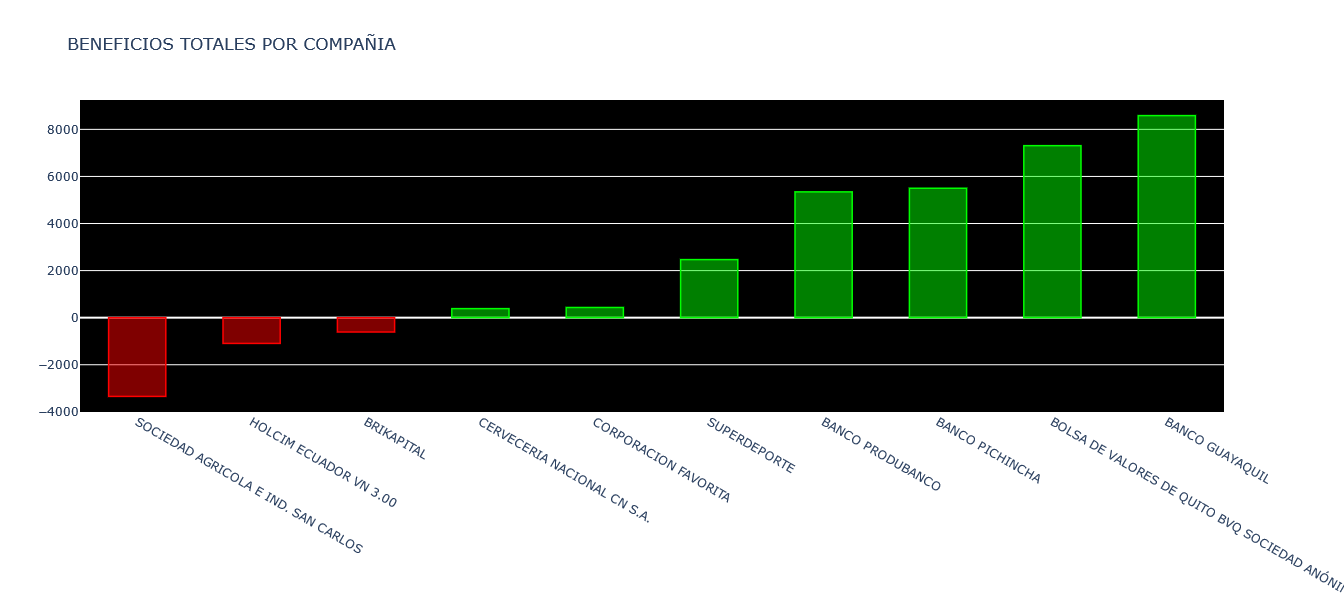

In [26]:
import chart_studio.plotly as py
import plotly.graph_objects as go
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)

resultados_cias = (reporte.resultados()['TOTAL']-monto_invertido/num_activos).sort_values()

x = resultados_cias.index
y = resultados_cias.values

bins = [-100_000, 0, 100_000]
labels = ['Rojo', 'Verde']

colors = {'Rojo': 'rgba(255, 0, 0, 0.5)',
          'Verde': 'rgba(0, 255, 0, 0.5)'}

df = pd.DataFrame({'y': y,
                   'x': x,
                   'label': pd.cut(y, bins=bins, labels=labels)})

bars = []
for label, label_df in df.groupby('label'):
    bars.append(go.Bar(x=label_df.x,
                       y=label_df.y,
                       name=label,
                       marker={'color': colors[label],}))
    
layout = { "title": "BENEFICIOS TOTALES POR COMPAÑIA", 
          "width": 900, 
          "height": 600,
          "plot_bgcolor": 'rgb (0, 0, 0)'}#None}

fig = go.FigureWidget(data=bars, layout=layout)   
fig.update_layout(showlegend=False)

fig.update_traces( marker_line_color='rgb (0, 255, 0)',
                  marker_line_width=1.5, width=0.5, hovertemplate = '%{y:$.0f}<extra></extra>',
                  selector={'marker_color': 'rgba(0, 255, 0, 0.5)'})

fig.update_traces( marker_line_color='rgb (255, 0, 0)',
                  marker_line_width=1.5, width=0.5, hovertemplate = '%{y:$.0f}<extra></extra>',
                  selector={'marker_color': 'rgba(255, 0, 0, 0.5)'})

fig.show()

### Revalorización del precio de la acción VS ingresos por dividendos recibidos

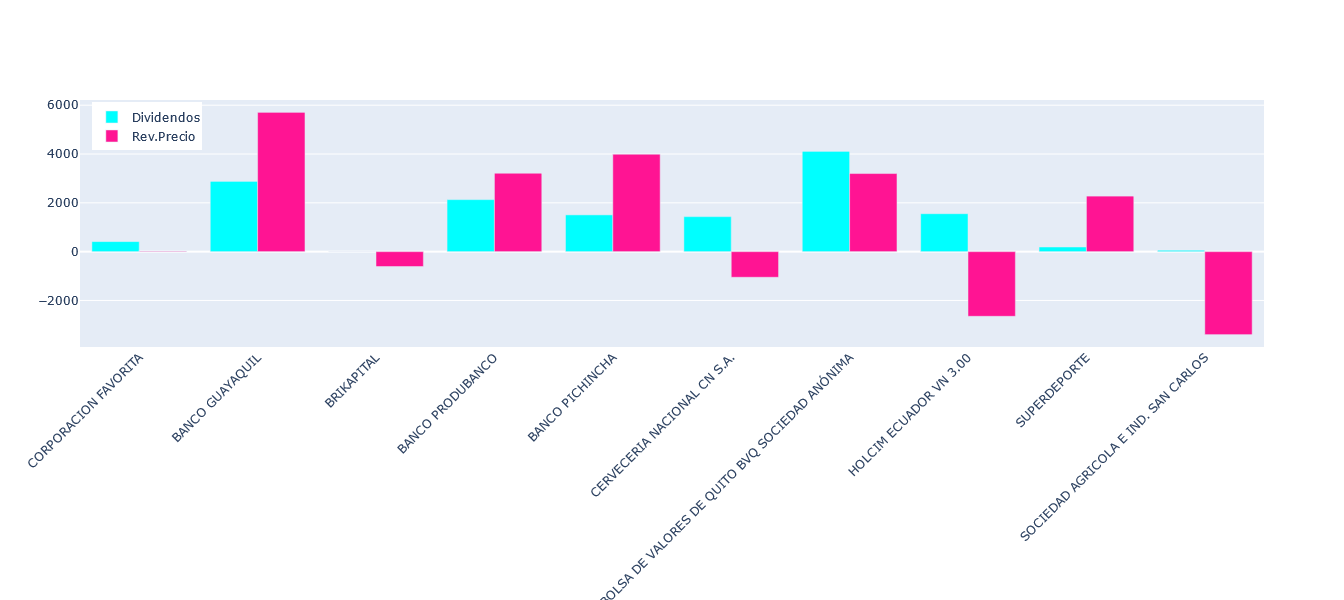

In [27]:
div_vs_precio = reporte.resultados()[['DIVIDENDOS', 'REV. ACCIONES']]
div_vs_precio["REV. ACCIONES"] -= monto_invertido / num_activos

cias = div_vs_precio.index

fig2 = go.Figure()
fig2.add_trace(go.Bar(
    x=cias,
    y=div_vs_precio['DIVIDENDOS'],
    name='Dividendos',
    marker_color='aqua'
))
fig2.add_trace(go.Bar(
    x=cias,
    y=div_vs_precio['REV. ACCIONES'],
    name='Rev.Precio',
    marker_color='deeppink'
))


fig2.update_layout(barmode='group', xaxis_tickangle=-45, height=600, width=920, legend=dict(yanchor="top",
    y=0.99, xanchor="left",x=0.01))
fig2.update_traces( hovertemplate = '%{y:$.0f}<extra></extra>')
fig2.show()

## Comparación con otras alternativas de inversión

Para evaluar mejor el desempeño de las principales acciones de compañias ecuatorianas en la decada pasada, lo debemos hacer comparando con otra/s alternativa/s que hubiesen sido posibles. Como se trata de renta variable las compararemos con los principales indices bursátiles de la bolsa estadounidense.

|      INDICES ACCIONARIOS     | TICKER |
|------------------------------|--------|
| S&P 500                      | ^GSPC  |
| Dow Jones Industrial Average | ^DJI   |
| NASDAQ Composite             | ^IXIC  |
| NASDAQ 100                   | ^NDX   |

In [28]:
import pandas_datareader as pdr

us_indices = ['^GSPC', '^DJI', '^IXIC', '^NDX']
data = pdr.get_data_yahoo(us_indices, start=inicio, end=fin, interval = 'd')['Adj Close']

In [29]:
def balance_cias(seleccion):

    balances = pd.DataFrame()
    lista_flujos = []
    
    for emisor in seleccion:

        df = reporte.balance(emisor)
        df['REINVERSION'] = df['DIVIDENDO'] / df['PRECIO']
        df['TOTAL.ACCIONES'] = df['ACC.POS'] + df['REINVERSION'].cumsum() * df['SPLIT'].cumprod()
        df['BALANCE.AJUST'] = df['PRECIO'] * df['TOTAL.ACCIONES']
        lista_flujos.append(df['BALANCE.AJUST'].rename(emisor))

    return balances.append(lista_flujos).T

In [30]:
import pandas_bokeh
pandas_bokeh.output_notebook()

balances = balance_cias(seleccionadas)
balances_consolidados = pd.DataFrame(balances.ffill().sum(axis=1), columns=['EMP. EC'])
balances_consolidados.index.rename("Date", inplace=True)
indices = pd.merge(balances_consolidados, data, on="Date", how='outer').groupby(pd.Grouper(freq='m')).mean().bfill()
indices.rename(columns={'^GSPC': 'S&P 500','^DJI': 'DOW JONES','^IXIC': 'NASDAQ Composite','^NDX': 'NASDAQ 100'}, inplace=True)

plot=(indices/indices.iloc[0]-1).plot_bokeh(
    kind="line",
    title="Empresas ecuatorianas VS Indices americanos",
    xlabel="Fecha",
    ylabel="Rendimiento",
    yticks=[0, 0.25, 0.5, 0.75, 1],
    ylim=(-0.25, 1),
    colormap=["red", "blue", "green", 'orange', 'cyan'],
    number_format="1%",
    legend = "top_left",
    figsize=(800,480))

Loading BokehJS ...

## Conclusiones

En esta ocasión, las 10 acciones más cotizadas de los últimos 3 años, mostró un desempeño un poco por debajo comparado al de la década pasada, aún así obtuvo un rendimiento parecido al mercado de bonos. Tengo poco más que agregar con respecto a las conclusiones del análisis de la década pasada.

>La acción de **CORPORACION FAVORITA** vuelve a decepcionar esta vez con más fuerza aún con un paupérrimo 1.4%. **Cervecería Nacional** ha sufrido el deterioro de su negocio, en los últimos 3 años, sin llegar a alcanzar ni un 1% de rentabilidad anual, después de un final de década de ensueño para sus accionistas. Lo que si vemos es el repunte  del sector bancario, cuyas acciones de las empresas de este sector fueron las más rentables de los últimos años.
